# Ecuaciones de Navier Stokes con fuerzas externas, esquema McCormack

Las ecuaciones de Navier-Stokes compresibles se pueden escribir de la siguiente forma

$$\frac{\partial \rho}{\partial t} + \nabla (\rho \underline{u}) = 0$$

$$\frac{\partial \rho \underline{u}}{\partial t} + \nabla (\rho \underline{uu})+\nabla P = \rho\nu \nabla^2 \underline{u} + \rho \underline{F}$$

Donde $\underline{u}$ es el vector de velocidad, $\rho$ la densidad, $\nu$ la viscosidad dinámica, $\underline{F}$ la fuerzas externas por unidad de volumen y $\underline{uu}$ el tensor $(\underline{uu})_{ij}=u_i u_j$

En este notebook ya no tomaremos $F=0$.

La primera de estas ecuaciones es la conservación de la masa y la segunda es la conservación de momento. Para el caso de tratar con liquidos se puede hacer la aproximación de fluido incompesible, es decir la densidad es constante, $\rho = \text{cte}$.

Bajo esta aproximación se las ecuaciones de Navier-Stokes se reducen a las siguientes

$$\nabla \underline{u} = 0$$

$$\frac{\partial \underline{u}}{\partial t} + (\underline{u}|\cdot\nabla) \underline{u}+\frac{1}{\rho}\nabla P = \nu \nabla^2 \underline{u} + \underline{F}$$

Resulta que tomando la divergencia de la ecuación de momento se puede mostrar que se obtiene una ecuación de Poisson para la presión cuando se considera el tiempo como continuo.

$$\frac{\partial^2 P}{\partial x^2}+\frac{\partial^2 P}{\partial y^2} = \rho\left(\frac{\partial F}{\partial x}+\frac{\partial G}{\partial y}\right)-\rho \left(\left(\frac{\partial u}{\partial x}\right)^2+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\left(\frac{\partial v}{\partial y}\right)^2 \right)$$

Para el caso discontinuo se llega a otra ecuación que se debe de resolver otra ecuación

$$\frac{\partial^2 P}{\partial x^2}+\frac{\partial^2 P}{\partial y^2} = \rho\left(\frac{\partial F}{\partial x}+\frac{\partial G}{\partial y}\right)-\rho \left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right)+\left(\frac{\partial u}{\partial x}\right)^2+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\left(\frac{\partial v}{\partial y}\right)^2 \right)$$

Notemos que en el caso discontinuo aparece el término $$\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right)$$
Que debería ser cero por la ecuación de continuidad, sin embargo debido a errores numéricos en general $$\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\neq 0$$ por lo tanto se debe de tomar en cuenta como término de corrección.

Donde $\underline{u} = (u,v)$ y $\underline{F} = (F,G)$ y 

Por lo tanto llegamos a un sistema de ecuaciones diferenciales parciales para nuestras tres variables

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial x} = -\frac{1}{\rho}\frac{\partial P}{\partial x} + \nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right)+F\\
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial x} = -\frac{1}{\rho}\frac{\partial P}{\partial y} + \nu \left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2} \right)+G\\
\frac{\partial^2 P}{\partial x^2}+\frac{\partial^2 P}{\partial y^2} =\rho\left(\frac{\partial F}{\partial x}+\frac{\partial G}{\partial y}\right)+\rho \left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right)-\left(\frac{\partial u}{\partial x}\right)^2-2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}-\left(\frac{\partial v}{\partial y}\right)^2 \right)$$
Donde $\underline{F}=(F,G)$

Otra cantidad que puede ser de interes es el valor de la vorticidad que vamos a definir como

$$\xi = \nabla \times \vec{u}$$

Pero como estamos en dos dimensiones podemos reescribir a $\xi$ 
$$\xi = \frac{\partial u}{\partial y} - \frac{\partial v}{\partial x}$$

In [1]:
#Se importan las librerias necesarias
from numpy import *
from matplotlib.pyplot import *
from matplotlib import animation
%matplotlib inline

# importar el script para redireccionar el video 
%run 'libreria_video_html.ipynb'

Para el caso de la ecuación de Poisson creamos una función que nos da el término no homogeneo, es decir 
$$\rho\left(\frac{\partial F}{\partial x}+\frac{\partial G}{\partial y}\right)+\rho \left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right)-\left(\frac{\partial u}{\partial x}\right)^2-2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}-\left(\frac{\partial v}{\partial y}\right)^2 \right)$$

In [3]:
def poisson_rec(um, vm, p1, x, y, dt, dx, dy, F, G, n_iteraciones, cond_frontera, f):
    p = p1.copy()
    pn = zeros_like(p1)
    f[1:-1, 1:-1] = rho*((F[1:-1,2:]-F[1:-1,0:-2])/(2.*dx)+(G[2:,1:-1]-G[0:-2,1:-1])/(2.*dy)+\
                        ((um[1:-1,2:]-um[1:-1,0:-2])/dx+(vm[2:,1:-1]-vm[0:-2,1:-1])/dy)/(2.*dt)-\
                        ((um[1:-1,2:]-um[1:-1,0:-2])/(2.*dx))**2-((vm[2:,1:-1]-vm[0:-2,1:-1])/(2.*dy))**2-\
                        2*((um[2:,1:-1]-um[0:-2,1:-1])/(2.*dy))*((vm[1:-1,2:]-vm[1:-1,0:-2])/(2.*dx)))
    for i in range(n_iteraciones):
        pn = p.copy()
        #Se aplica la condicion de estabilidad en el interior del dominio
        p[1:-1,1:-1] = ( dy**2*(pn[1:-1,2:]+pn[1:-1,0:-2,]) + dx**2*(pn[2:,1:-1]+pn[0:-2,1:-1]) -\
                        dx**2 *dy**2 *f[1:-1,1:-1] )/(2*(dx**2+dy**2))
        #Se aplican las condiciones de frontera
        p = cond_frontera(p, x, y, dx, dy, F, G)
    return pn


def discret_vel(un, vn, pn, dx, dy, dt, x, y, cond_frontU, cond_frontV, rho, nu, F, G):
    U = zeros_like(un)
    U_ = zeros_like(un)
    V = zeros_like(vn)
    V_ = zeros_like(vn)
    
    U_[1:-1,1:-1] = un[1:-1,1:-1] - dt/dx * (un[1:-1,2:]**2-un[1:-1,1:-1]**2) \
                    - dt/dy * (un[2:,1:-1]*vn[2:,1:-1]-un[1:-1,1:-1]*vn[1:-1,1:-1])\
                    - dt/dx * (pn[1:-1,2:]-pn[1:-1,1:-1])/rho + dt * F[1:-1,1:-1]\
                    + nu*dt/dx**2 * (un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])\
                    + nu*dt/dy**2 * (un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1])
                    
    V_[1:-1,1:-1] = vn[1:-1,1:-1] - dt/dx * (un[1:-1,2:]*vn[1:-1,2:]-un[1:-1,1:-1]*vn[1:-1,1:-1]) \
                    - dt/dy * (vn[2:,1:-1]**2-vn[1:-1,1:-1]**2)\
                    - dt/dy * (pn[2:,1:-1]-pn[1:-1,1:-1])/rho + dt * G[1:-1,1:-1]\
                    + nu*dt/dx**2 * (vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])\
                    + nu*dt/dy**2 * (vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])
    
    U[1:-1,1:-1] = 0.5*( un[1:-1,1:-1] + U_[1:-1,1:-1]\
                        - dt/dx * (U_[1:-1,1:-1]**2 - U_[1:-1,0:-2]**2)\
                        - dt/dy * (U_[1:-1,1:-1]*V_[1:-1,1:-1] - U_[0:-2,1:-1]*V_[0:-2,1:-1])\
                        - dt/dx * (pn[1:-1,1:-1]-pn[1:-1,0:-2])/rho + dt * F[1:-1,1:-1]\
                        + nu*dt/dx**2 * (U_[1:-1,2:]-2*U_[1:-1,1:-1]+U_[1:-1,0:-2])\
                        + nu*dt/dy**2 * (U_[2:,1:-1]-2*U_[1:-1,1:-1]+U_[0:-2,1:-1])
                    )
    V[1:-1,1:-1] = 0.5*( vn[1:-1,1:-1] + V_[1:-1,1:-1]\
                        - dt/dx * (U_[1:-1,1:-1]*V_[1:-1,1:-1] - U_[1:-1,0:-2]*V_[1:-1,0:-2])\
                        - dt/dy * (V_[1:-1,1:-1]**2 - V_[0:-2,1:-1]**2)\
                        - dt/dx * (pn[1:-1,1:-1]-pn[0:-2,1:-1])/rho + dt * G[1:-1,1:-1]\
                        + nu*dt/dx**2 * (V_[1:-1,2:]-2*V_[1:-1,1:-1]+V_[1:-1,0:-2])\
                        + nu*dt/dy**2 * (V_[2:,1:-1]-2*V_[1:-1,1:-1]+V_[0:-2,1:-1])
                    )    
    
    Un = cond_frontU(U, V, pn, dx, dy, dt, x, y, F)
    Vn = cond_frontV(U, V, pn, dx, dy, dt, x, y, G)
    
    return Un, Vn

def vorticidad(un, vn, dx, dy):
    Xi = empty_like(un)
    Xi[1:-1,1:-1] = (un[0:-2,1:-1]-un[2:,1:-1])/(2*dy)-(vn[1:-1,0:-2]-vn[1:-1,2:])/(2*dx)
    return Xi

In [8]:
def avance_en_tiempo(u0, v0, p0, cond_frontU, cond_frontV, cond_frontP, nt, nx, ny, dx, dy, x, y, nu, rho,
                     sigma, n_iteraciones, F, G, flag=False):
    t = 0
    
    un = zeros((ny, nx))
    vn = zeros((ny, nx))
    Pn = zeros((ny, nx))
    f = zeros((ny, nx))
    Xin = zeros((ny, nx))
    
    if flag: 
        Uhist=[]
        Vhist=[]
        Phist=[]
        Xhist=[]
        thist=[]
    
    u = u0
    v = v0
    P = p0
    
    for n in range(nt):        
        #Se copia el valor de la funcion u en el arreglo un
        un = u.copy()
        vn = v.copy()
        Pn = P.copy()
        
        if flag: 
            Uhist.append(un)
            Vhist.append(vn)
            Phist.append(Pn)
            Xhist.append(Xin)
            thist.append(t)
        
        dt = sigma / (max(amax(un)/dx, amax(vn)/dy) + max(2*nu/dx**2, 2*nu/dy**2))
        t = t+dt

        #Para cada punto en el espacio se calcula el valor 
        #de la funcion en el tiempo siguiente
        P = poisson_rec(un, vn, Pn, x, y, dt, dx, dy, F, G, n_iteraciones, cond_frontP, f)
        
        u, v = discret_vel(un, vn, Pn, dx, dy, dt, x, y, cond_frontU, cond_frontV, rho, nu, F, G)
        
        Xin = vorticidad(u, v, dx, dy)
        
    if flag:
        return Uhist, Vhist, Phist, Xhist, thist
    else:
        return u, v, P, Xin, t

Hagamos el ejemplo de una tubería donde inicialmente las velocidades $u$ y $v$ son cero, al igual que la presión.
Por lo tanto las condiciones iniciales son:
$$u(x,y)=0\\v(x,y)=0\\p(x,y)=0$$
Consideremos las condiciones de frontera periódicas a lo largo del eje $x$, y que la velocidad del fluido es cero en las paredes de la tubería.
Por lo tanto las condiciones de frontera son:
$$
u(x,0)=u(x,1)=u(0,y)=u(1,y)=0\\
v(x,0)=v(x,1)=v(0,y)=v(1,y)=0\\
\frac{\partial p}{\partial y}(x,0)=\frac{\partial p}{\partial y}(x,1)=\frac{\partial p}{\partial y}(0,y)=\frac{\partial p}{\partial y}(1,y)=0\\
F = 0\\ G=-1
$$

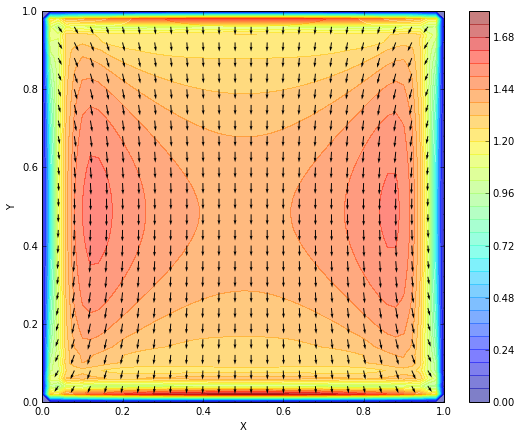

In [16]:
def cond_front_u(um, vm, pm, dt, dx, dy, x, y, F):
    um[:, 0] = 0   # en x=0
    um[:, -1] = 0  # en x=1
    um[0,:] = 0    # en y=0
    um[-1,:] = 0   # en y=1
    return um

def cond_front_v(um, vm, pm, dt, dx, dy, x, y, G):
    vm[:, 0] = 0   # en x=0
    vm[:, -1] = 0  # en x=1
    vm[0,:] = 0    # en y=0
    vm[-1,:] = 0   # en y=1
    return vm

def cond_front_p(pm, x, y, dx, dy, F, G):
    pm[:, 0] = 1.   # en x=0
    pm[:, -1] = 1. # en x=1
    pm[0,:] = 1.     # en y=0
    pm[-1,:] = 1.   # en y=1
    return pm 

nx = 51
ny = 51
nt = 100
dx = 1./(nx-1)
dy = 1./(ny-1)
sigma = 0.1
n_iteraciones = 1000
nu = 1.
rho = 1.

dt=sigma*dx*dy/nu
N = 2
x = linspace(0., 1., nx)
y = linspace(0., 1., ny)
X, Y = meshgrid(x, y)

#Se define un arreglo de puros ceros
u0 = zeros((ny, nx))
v0 = zeros((ny, nx))
p0 = zeros((ny, nx))

F = zeros((ny, nx))
G = -1000*ones((ny, nx))

#Se imponen las condiciones de frontera
u0 = cond_front_u(u0, v0, p0, dt, dx, dy, x, y, F)
v0 = cond_front_v(u0, v0, p0, dt, dx, dy, x, y, G)
p0 = cond_front_p(p0, x, y, dx, dy, F, G)

U, V, P, Xi, t = avance_en_tiempo(u0, v0, p0, cond_front_u, cond_front_v, cond_front_p, 
                              nt, nx, ny, dx, dy, x, y, nu, rho, sigma, n_iteraciones, F, G)
MagU = sqrt(U**2+V**2)
fig = figure(figsize=(9,7), dpi=100)
contourf(X, Y, MagU, 30, alpha=0.5)
colorbar()
quiver(X[::N,::N], Y[::N,::N], U[::N,::N], V[::N,::N])
xlabel('X')
ylabel('Y');

In [ ]:
def cond_front_u(um, vm, pm, dt, dx, dy, x, y, F):
    um[:, 0] = 0   # en x=0
    um[:, -1] = 0  # en x=1
    um[0,:] = 0    # en y=0
    um[-1,:] = 0   # en y=1
    return um

def cond_front_v(um, vm, pm, dt, dx, dy, x, y, G):
    vm[:, 0] = 0   # en x=0
    vm[:, -1] = 0  # en x=1
    vm[0,:] = 0    # en y=0
    vm[-1,:] = 0   # en y=1
    return vm

def cond_front_p(pm, x, y, dx, dy, F, G):
    pm[:, 0] = 1.   # en x=0
    pm[:, -1] = 1. # en x=1
    pm[0,:] = 1.     # en y=0
    pm[-1,:] = 1.   # en y=1
    return pm 

lx = 2.
ly = 1.
nx = 151
ny = 101
nt = 100
dx = lx/(nx-1)
dy = ly/(ny-1)
sigma = 0.2
n_iteraciones = 1000
nu = 0.1
rho = 1.

dt = sigma*dx*dy/nu
N = 4

x = linspace(0., lx, nx)
y = linspace(0., ly, ny)
X, Y = meshgrid(x, y)

#Se define un arreglo de puros ceros
u0 = zeros((ny, nx))
v0 = zeros((ny, nx))
p0 = zeros((ny, nx))

u0[0:ny/2,:] = tanh(50*(Y[0:ny/2, :]-0.25*ly))
u0[ny/2:,:] = tanh(50*(0.75*ly-Y[ny/2:, :]))

F = zeros((ny, nx))
G = zeros((ny, nx))

#Se imponen las condiciones de frontera
u0 = cond_front_u(u0, v0, p0, dt, dx, dy, x, y, F)
v0 = cond_front_v(u0, v0, p0, dt, dx, dy, x, y, G)
p0 = cond_front_p(p0, x, y, dx, dy, F, G)

Uh, Vh, Ph, Xih, th =  avance_en_tiempo(u0, v0, p0, cond_front_u, cond_front_v, cond_front_p, 
                              nt, nx, ny, dx, dy, x, y, nu, rho, sigma, n_iteraciones, F, G, True)
UMag = [sqrt(Uh[i]**2+Vh[i]**2) for i in range(0,nt)]

# Se define el ambiente en el que queremos hacer la animación
figanim = figure(figsize=(8,7))
Ax = figanim.add_subplot(111)
Ax.set_xlim(0,1)
Ax.set_ylim(0,1)
cbar_ax = figanim.add_axes([0.85, 0.15, 0.05, 0.7])

def init():
    Ax.cla()
    campo_vectorial = Ax.quiver([],[],[],[])
    return campo_vectorial,

# Esta funcion se llama de manera secuencial para cada elemento i.
def animate(i,Ax,fig):
    Ax.cla()
    cbar_ax.cla()
    figanim.subplots_adjust(right=0.8)
    contornof = Ax.contourf(X, Y, UMag[i], 25)
    figanim.colorbar(contornof, cbar_ax)
    campo_vectorial = Ax.quiver(X[::N,::N], Y[::N,::N], Uh[i][::N,::N], Vh[i][::N,::N])
    return campo_vectorial, contornof,

# Se llama a la animacion.  blit=True es para que solo se dibije las partes de la imagen que tienen cambios.
animation.FuncAnimation(figanim, animate, init_func=init, frames=nt, fargs=(Ax, figanim), interval=5)
#anim.save("Animacion.mp4", fps=10)